## Word2Vec


1. Implemented word2vec with very simple example using tensorflow
2. word2vec is vector representation for words with similarity

## Collect Data
we will use only 10 sentences to create word vectors

In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

## Remove Stop words

In order for efficiency of creating word vector, we will remove commonly used words

In [3]:
def remove_stop_words(corpus):
    stop_words=['is','a','will','be']
    result=[]
    for text in corpus:
        temp=text.split(' ')
        for stop_word in stop_words:
            if stop_word in temp:
                temp.remove(stop_word)
        result.append(' '.join(temp))
    return result
        

In [4]:
corpus=remove_stop_words(corpus)

In [5]:
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

## Finding distinct words

In [6]:
words=[]
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words=set(words)
print(words)
print("Type of words object is :{}".format(type(words)))

{'queen', 'young', 'king', 'boy', 'prince', 'pretty', 'woman', 'man', 'wise', 'strong', 'princess', 'girl'}
Type of words object is :<class 'set'>


## Data generation for Skip Gram
we will generate label for each word using skip gram.

In [11]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

#### Converting each sentence in list of words

In [8]:
sentences=[]
for sentence in corpus:
    sentences.append(sentence.split())
    
sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [13]:
import pandas as pd
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [14]:
df.shape

(52, 2)

In [15]:
word2int #Sequence of word

{'queen': 0,
 'young': 1,
 'king': 2,
 'boy': 3,
 'prince': 4,
 'pretty': 5,
 'woman': 6,
 'man': 7,
 'wise': 8,
 'strong': 9,
 'princess': 10,
 'girl': 11}

## Define Tensorflow Graph

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
#import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1 #Putting 1 based on index
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    
print(X[-1],x)
print(Y[-1],y)

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] queen
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] girl


## Train

In [20]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  4.4776435
iteration 3000 loss is :  1.8027045
iteration 6000 loss is :  1.7555273
iteration 9000 loss is :  1.7320225
iteration 12000 loss is :  1.7147434
iteration 15000 loss is :  1.7023574
iteration 18000 loss is :  1.693245


In [21]:

# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[-0.672038    4.246466  ]
 [-0.3687386  -0.4761023 ]
 [ 0.9364388  -0.09809738]
 [ 0.9631741  -0.2201168 ]
 [ 5.530604   -0.42049533]
 [-3.409277    2.7739742 ]
 [-0.05018061  1.1166308 ]
 [ 4.247682   -0.09729904]
 [-1.979397    1.3794423 ]
 [ 1.5136449  -3.5952635 ]
 [-0.5061862   2.849076  ]
 [-0.79909784  4.431391  ]]


In [23]:
# Now 2nd layer (W2 + b2) is actually the word look up table with 11 W and B which will feed into soft max.
vectors2 = sess.run(W2 + b2)
print(vectors2)

[[-4.277472    1.9069762   1.6850348   1.6673443   1.2528493  -0.29207397
  -4.756967    1.0885818  -0.26935285  1.78755    -3.0182872  -2.6999853 ]
 [ 0.76764935  1.817965   -3.5960925  -2.2989502  -2.9623973   0.7582585
   0.63217825 -4.035384    1.2377651   0.30350393  1.0096555   0.94098216]]


## Word Vector in Table

In [25]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,queen,-0.672038,4.246466
1,young,-0.368739,-0.476102
2,king,0.936439,-0.098097
3,boy,0.963174,-0.220117
4,prince,5.530604,-0.420495
5,pretty,-3.409277,2.773974
6,woman,-0.050181,1.116631
7,man,4.247682,-0.097299
8,wise,-1.979397,1.379442
9,strong,1.513645,-3.595263


## Word vector in Chart

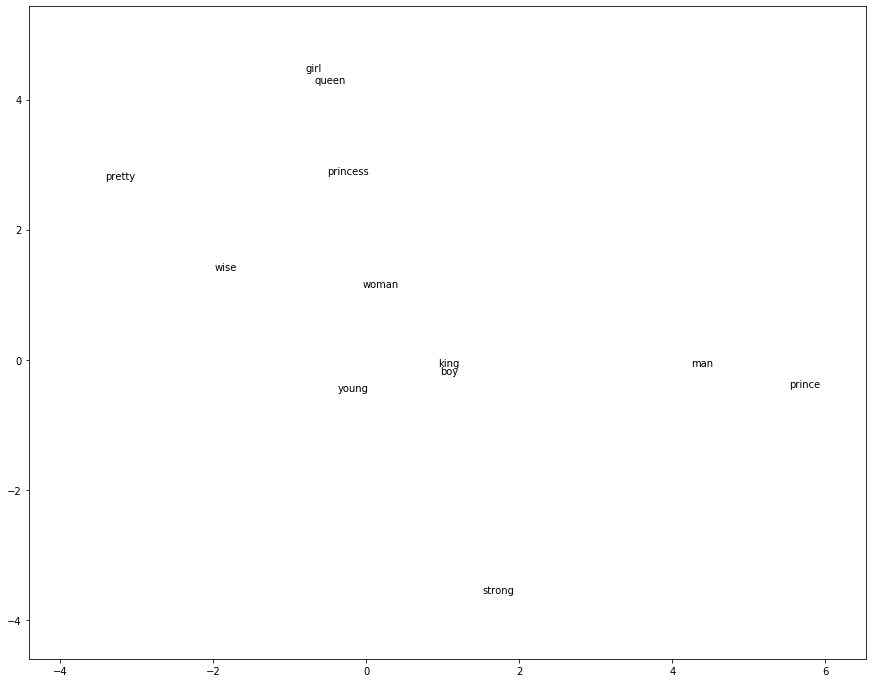

In [28]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (15,13)

plt.show()